In [1]:
# %pip show pip
# %pip install -U scikit-learn
# python3 -m pip3 install jupyter notebook -U

In [10]:

import pandas as pd
import numpy as np
from google.colab import drive 
import sys
import os
drive.mount('/content/drive', force_remount=True) 

os.chdir("/content/drive/MyDrive/Colab Notebooks/CFT")
!ls

Mounted at /content/drive
changepoint_detection.py  LICENSE	   README.md	     train.py
datasets		  metafeatures.py  requirements.txt  ts2vec.ipynb
datautils.py		  models	   scripts	     ts2vec.py
dl_meta_features.ipynb	  __pycache__	   tasks	     utils.py


In [1]:
# %%bash
# ## For when you're ready to save your changes...
# git commit -a -m "message"
# git push -u origin main

In [153]:
%load_ext autoreload
%autoreload 2
from train_utils import get_data, train_model, save_checkpoint_callback
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from matplotlib import pyplot as plt
from sklearn import linear_model
from utils import standardize
from datetime import datetime
from models.losses import *
from ts2vec import TS2Vec
from pathlib import Path
from tqdm import tqdm
from os import walk
import pandas as pd
import numpy as np
import datautils
import torch
import json





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# TODO: Challenges to solve with stock data
    # Have to deal with weekends - time series not continuous (maybe include time features like hour and daily)
    # df.resample('D').last().isna().mean()
    # Have to deal with hours between stock opened and stock closed

In [150]:
base_path = "/Users/abuj/Documents/GitHub/"     #"/content/drive/MyDrive/Colab Notebooks/"  #"/Users/abuj/Documents/GitHub/
timeframe = "day"
data_dict, train_data, exp_train_data, test_data, exp_test_data = get_data(base_path, timeframe)

100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


(10976, 7, 5) (10976, 9)
(1939, 7, 5) (1939, 9)


In [7]:
short_cpd_lookback_window_length    = 12
long_cpd_lookback_window_length     = 126

In [ ]:
#complete writing report 
#do experimentation
    #train using daily stock data
    #train using data from 
    #compare to other methods
        #vanilla ts2vec
        #tnc
        #and 2 more 
    #ablation study
#work on conclusion
    # how can project be improved 
    # limitations and e.t.c

In [20]:

# Train a TS2Vec model
model = TS2Vec(
    input_dims=train_data.shape[-1],
    device=0,
    output_dims=100,
    batch_size=64, 
   
)

loss_log = model.fit(
    train_data,
    expert_features=exp_train_data, # train_data.reshape(100, -1)[:,40:],
    verbose=True,
    use_expclr_loss=True,
    n_epochs=10
)

# # Compute timestamp-level representations for test set
# test_repr_tl = model.encode(test_data)  # n_instances x n_timestamps x output_dims

# Compute instance-level representations for test set
# test_repr_il = model.encode(test_data, encoding_window='full_series')  # n_instances x output_dims

# # Sliding inference for test set
# test_repr_si = model.encode(
#     test_data,
#     casual=True,
#     sliding_length=1,
#     sliding_padding=50
# )  # n_instances x n_timestamps x output_dims
# # (The timestamp t's representation vector is computed using the observations located in [t-50, t])

Epoch #0: loss=1.2245498570653615
Epoch #1: loss=1.0282297405309926
Epoch #2: loss=1.0041241022545522
Epoch #3: loss=0.9883346782533564
Epoch #4: loss=0.9822506695787232
Epoch #5: loss=0.9739925486365641
Epoch #6: loss=0.9690609181526573
Epoch #7: loss=0.9650646944612102
Epoch #8: loss=0.96838782612372
Epoch #9: loss=0.9641397429552315


In [ ]:
fn_load = "/Users/abuj/Documents/GitHub/CFT/saved_models/version1.pkl"

# Train a TS2Vec model
model_load = TS2Vec(
    input_dims=train_data.shape[-1],
    device=0,
    output_dims=100,
    batch_size=64, 
   
)

model_load.load(fn_load)

In [39]:
# data_dict[file[:-4]]['X_DATA_DICT']
TEST_ASSET = "XEL"

num_test_intances = int(pct_train*len(data_dict[TEST_ASSET]['Y_DATA']))

test_y = data_dict[TEST_ASSET]['Y_DATA'][num_test_intances:].dropna().iloc[:]

test_x = { idx: data_dict[TEST_ASSET]['X_DATA_DICT'][idx]  for idx in test_y.index if idx in data_dict[TEST_ASSET]['X_DATA_DICT'].keys() }

print( len(test_x) )
print( len(test_y) )

arrar_for_df = []
for idx in test_y.index[:]:
    arrar_for_df.append( model_load.encode(data_dict[TEST_ASSET]['X_DATA_DICT'][idx][np.newaxis, ...], encoding_window='full_series').reshape(-1) )

test_repr_il = pd.DataFrame(arrar_for_df, index = test_y.index)

273
273


In [122]:
pd.Series(test_x)[-1]

array([[-1.40463389, -1.40293307, -1.25823846, -1.28665324, -1.31515725],
       [-1.21893159, -0.99798297, -1.14345568, -1.29786965, -1.17359881],
       [-1.17779011, -0.86335268, -0.97614484, -0.70684089, -0.75158648],
       [-0.30470792, -0.12900071, -0.05827042,  0.02729921, -0.02621909],
       [-0.23705782, -0.13703659, -0.15607117,  0.01699193, -0.14245687],
       [-0.0418875 , -0.09035017, -0.05192658, -0.2586078 , -0.19285702],
       [-0.52204752, -0.68152562, -0.86599718, -0.98037146, -0.91902915]])

In [124]:

temp_x = pd.DataFrame(columns = cols_to_perform_ffd,index= test_x.keys())

for idx in temp_x.index:
    temp_x.loc[idx] = test_x[idx][-1]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(test_repr_il, test_y, test_size=0.13, random_state=42)
reg = linear_model.LinearRegression()
reg = RidgeClassifier()


reg.fit( X_train, np.sign( y_train['one_day_price_pred'] ) )

print( reg.score(X_train, np.sign( y_train['one_day_price_pred'] ) ) )
print( reg.score(X_test,  np.sign( y_test['one_day_price_pred'] ) ) )

0.7763713080168776
0.5555555555555556


In [41]:
# def save(self, fn):
#     ''' Save the model to a file.
    
#     Args:
#         fn (str): filename.
#     '''
#     if fn[-4:] == '.pkl':
#         fn = fn[:-4]

#     torch.save(self.net.state_dict(), fn + "_net.pkl")
#     torch.save(self.projection_head.state_dict(), fn + "_projection_head.pkl")
#     torch.save(self.rnn.state_dict(), fn + "_rnn.pkl")

# fn = "/Users/abuj/Documents/GitHub/CFT/saved_models/version2.pkl"

# save(model, fn)

In [111]:
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import ticker
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(15, 5), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=5).fit_transform(test_repr_il)

# X_embedded = PCA(n_components=2).fit_transform(test_repr_il)

gm = GaussianMixture(n_components=5, random_state=0).fit(test_repr_il)
labels = gm.predict(test_repr_il)

# X_embedded = pd.DataFrame(X_embedded,index=test_repr_il.index )

In [139]:
# temp_x
# X_embedded = TSNE(n_components=2, learning_rate='auto',
                #   init='random', perplexity=5).fit_transform(temp_x)
# X_embedded = PCA(n_components=2).fit_transform(temp_x)
X_embedded = pd.DataFrame(X_embedded,index=temp_x.index )

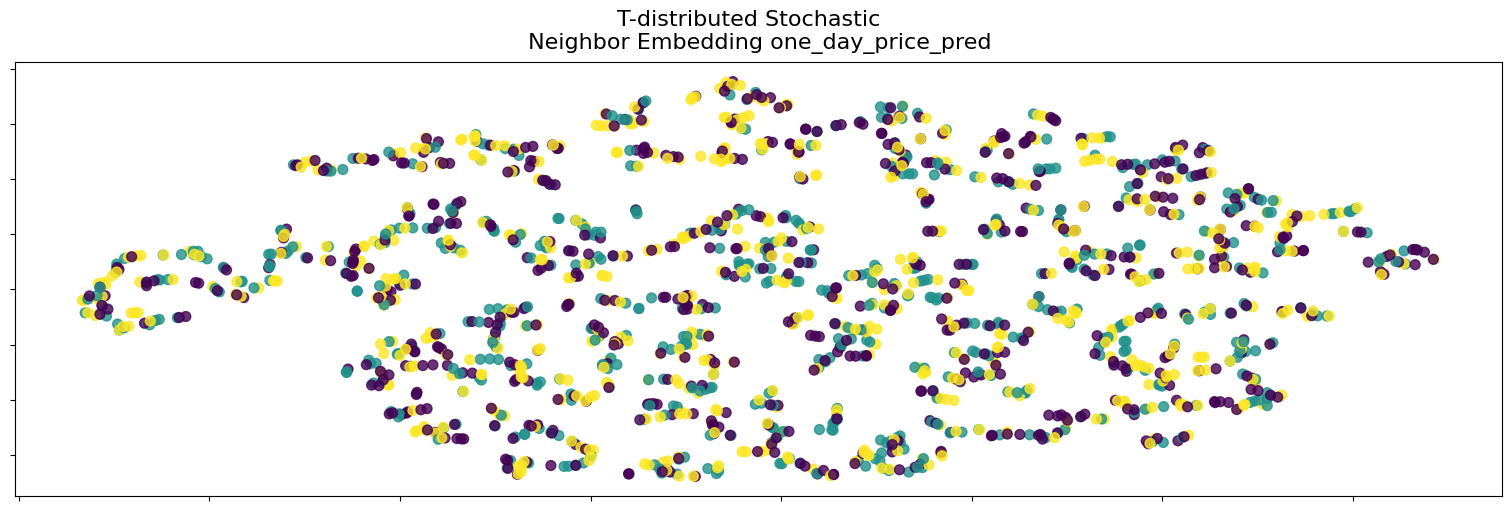

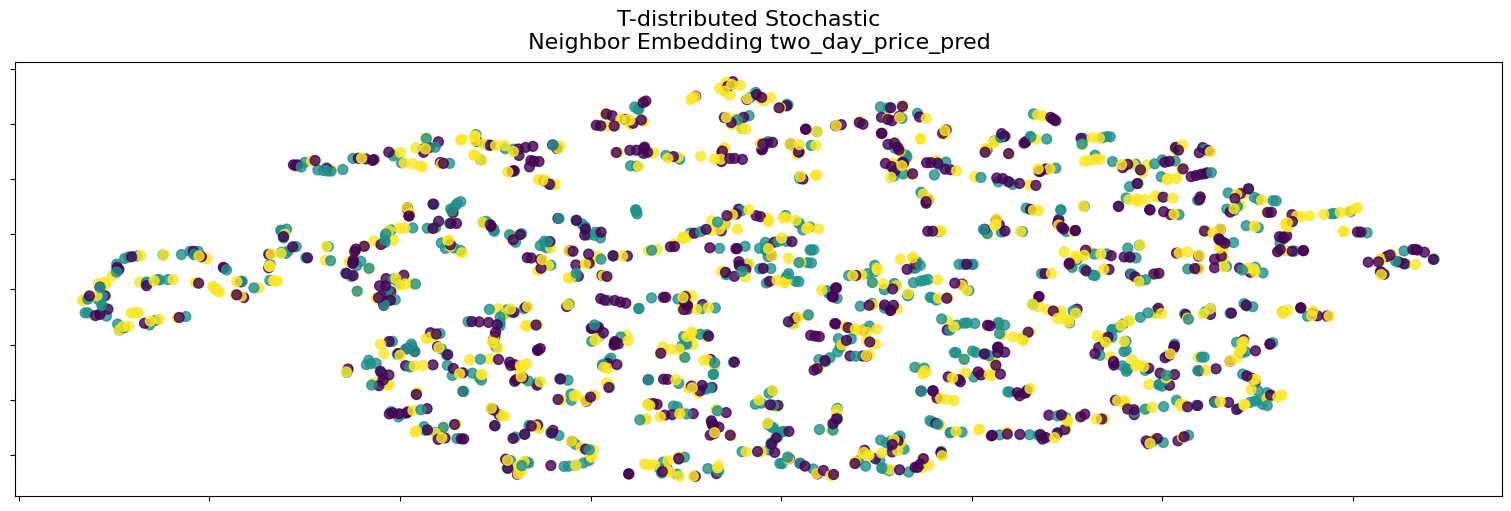

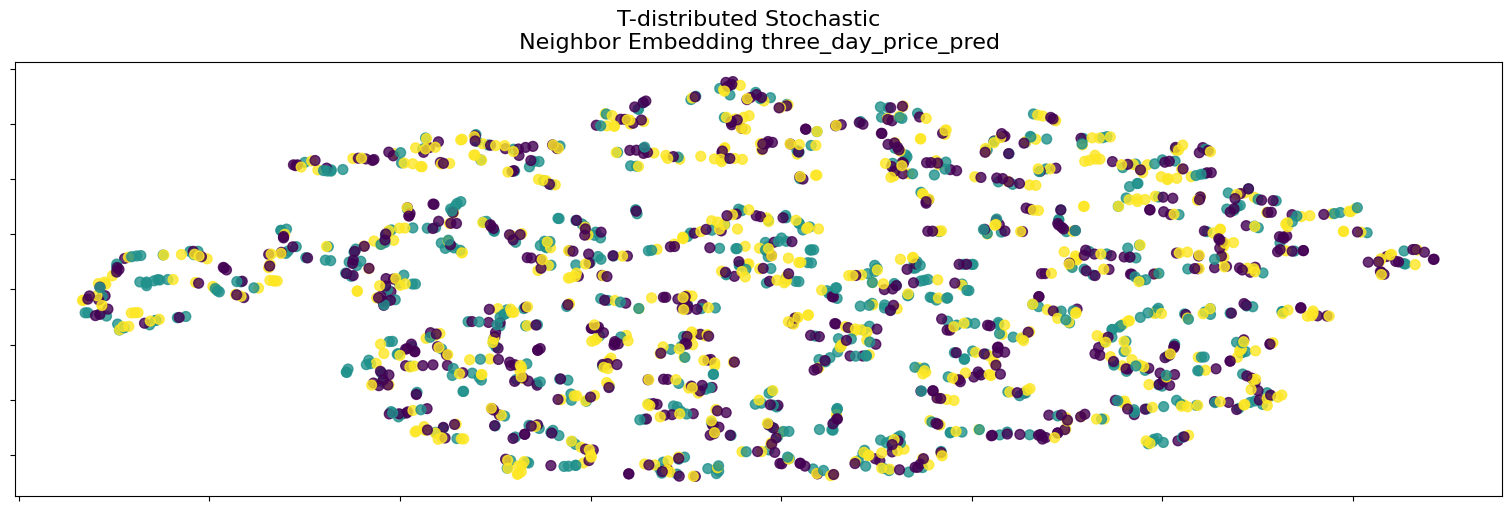

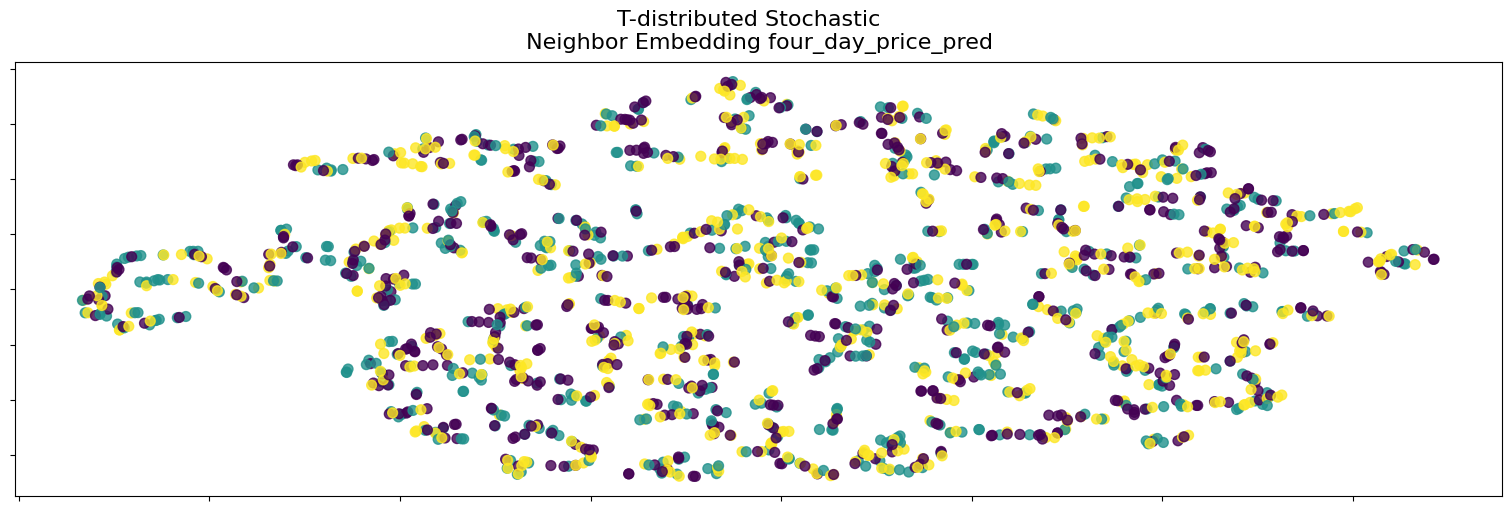

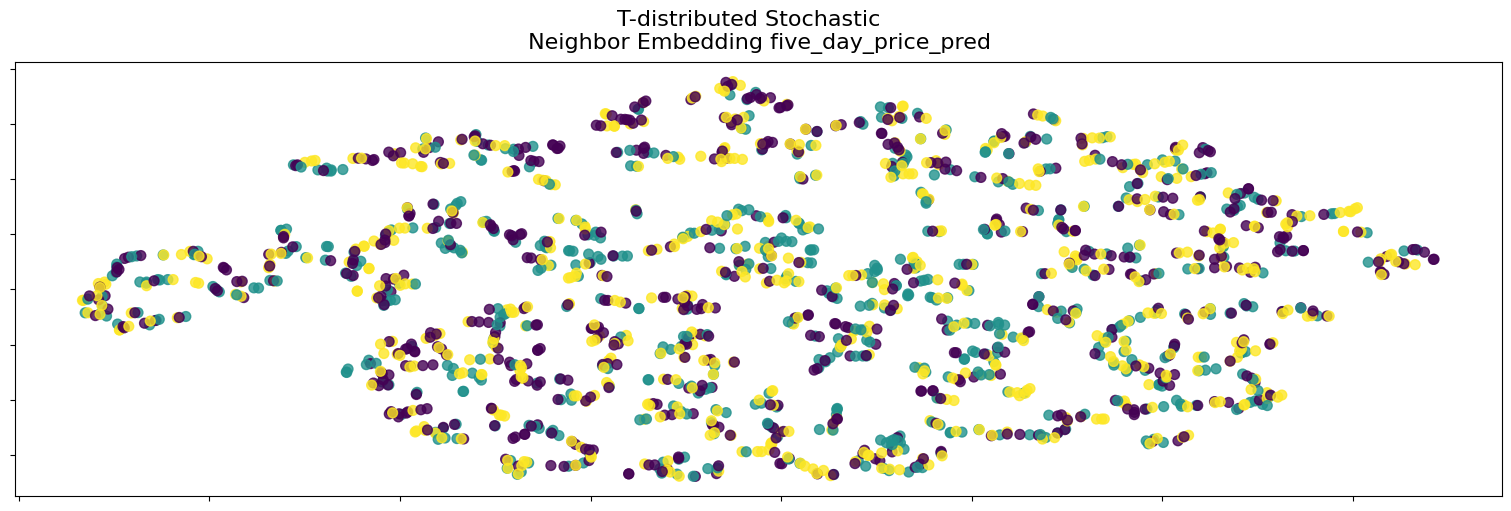

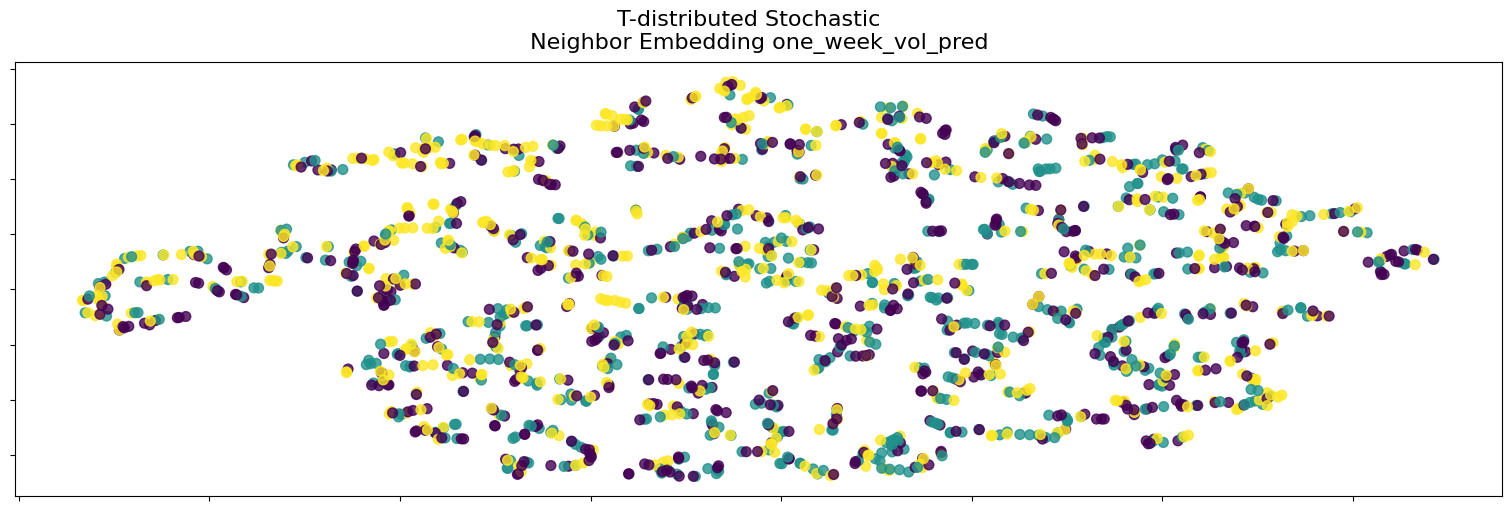

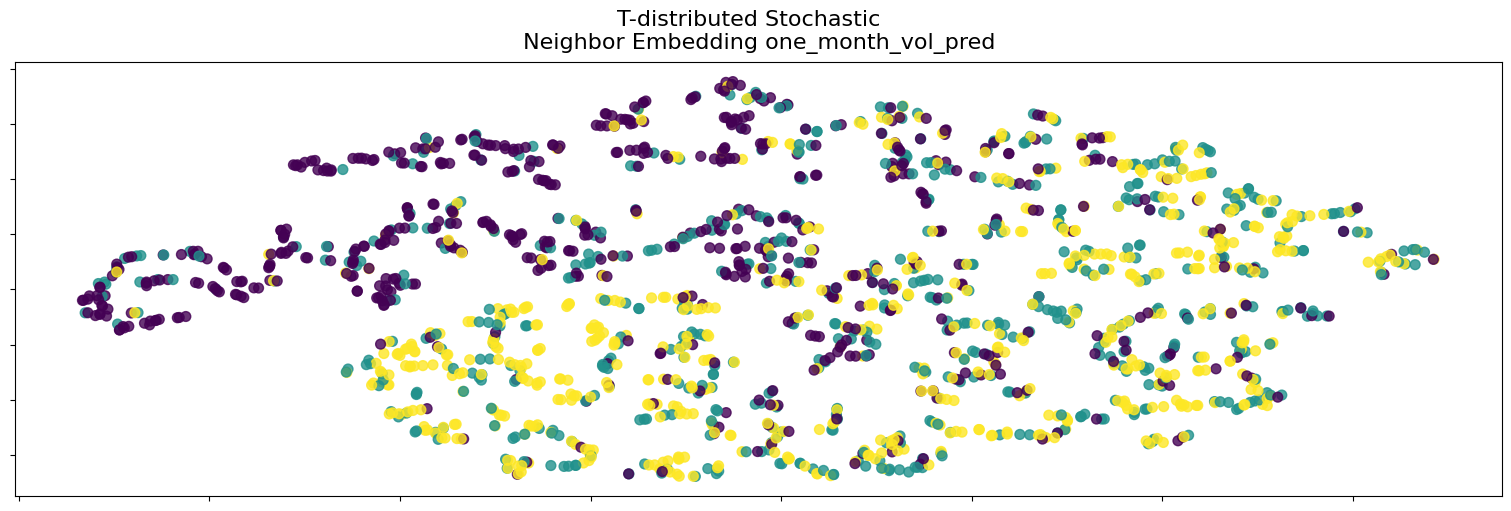

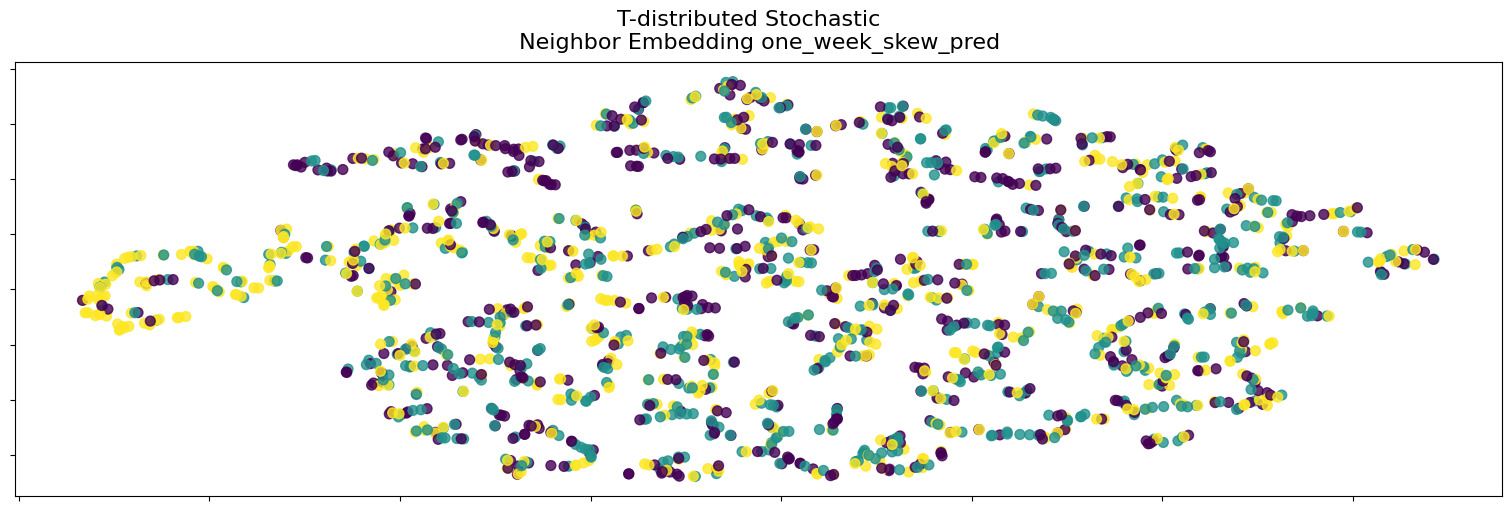

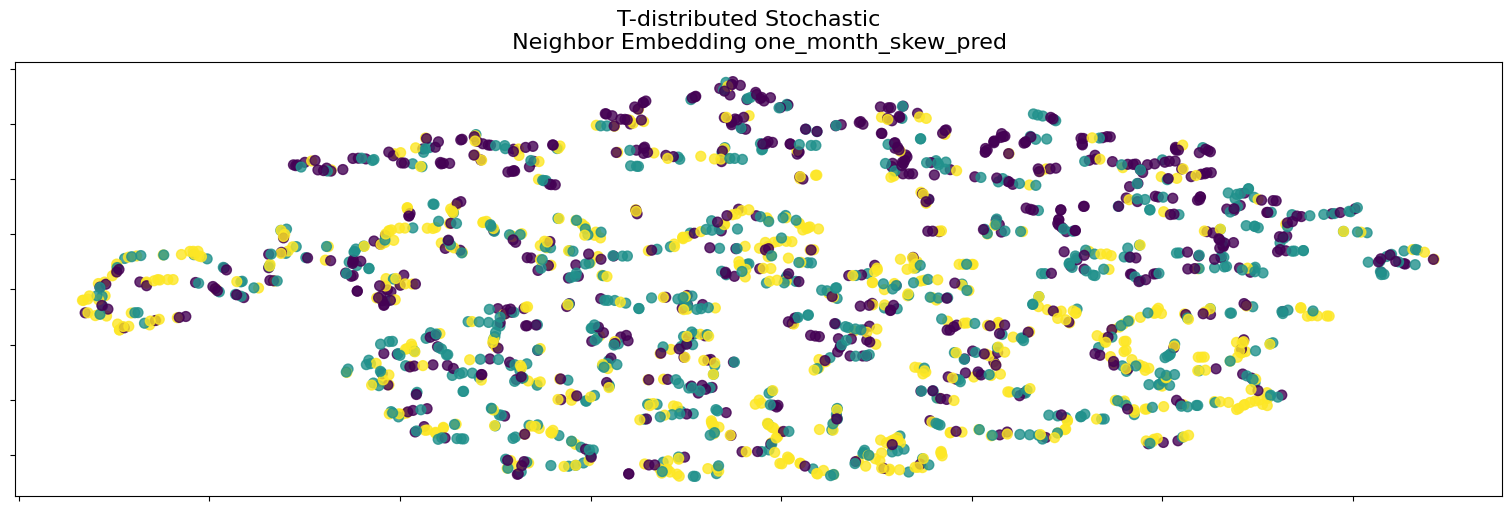

In [140]:
for col in test_y.columns:
    labels      = pd.qcut(test_y[col], 3, labels=False)[:]
    idx         = labels.index.intersection(X_embedded.index)
    labels      = labels.loc[idx]
    X_embedded  = X_embedded.loc[idx]

    plot_2d(X_embedded[:].values, labels, "T-distributed Stochastic  \n Neighbor Embedding " + col)

<AxesSubplot: >

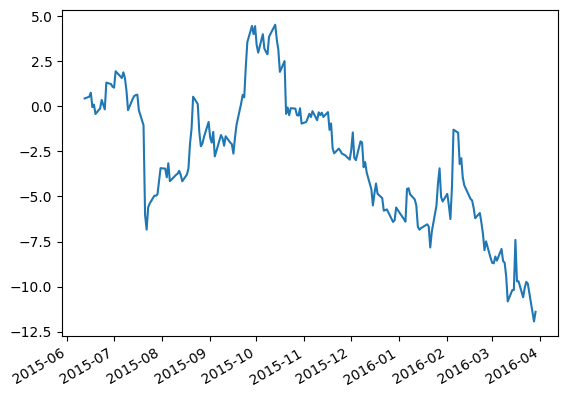

In [98]:
test_y['one_day_price_pred'][:200].cumsum().plot()

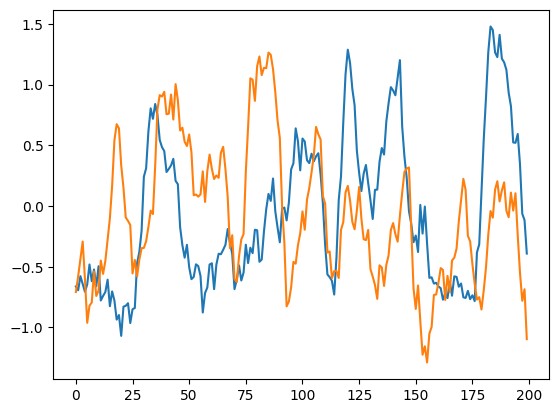

In [99]:
plt.plot(X_embedded[:200])

<AxesSubplot: >

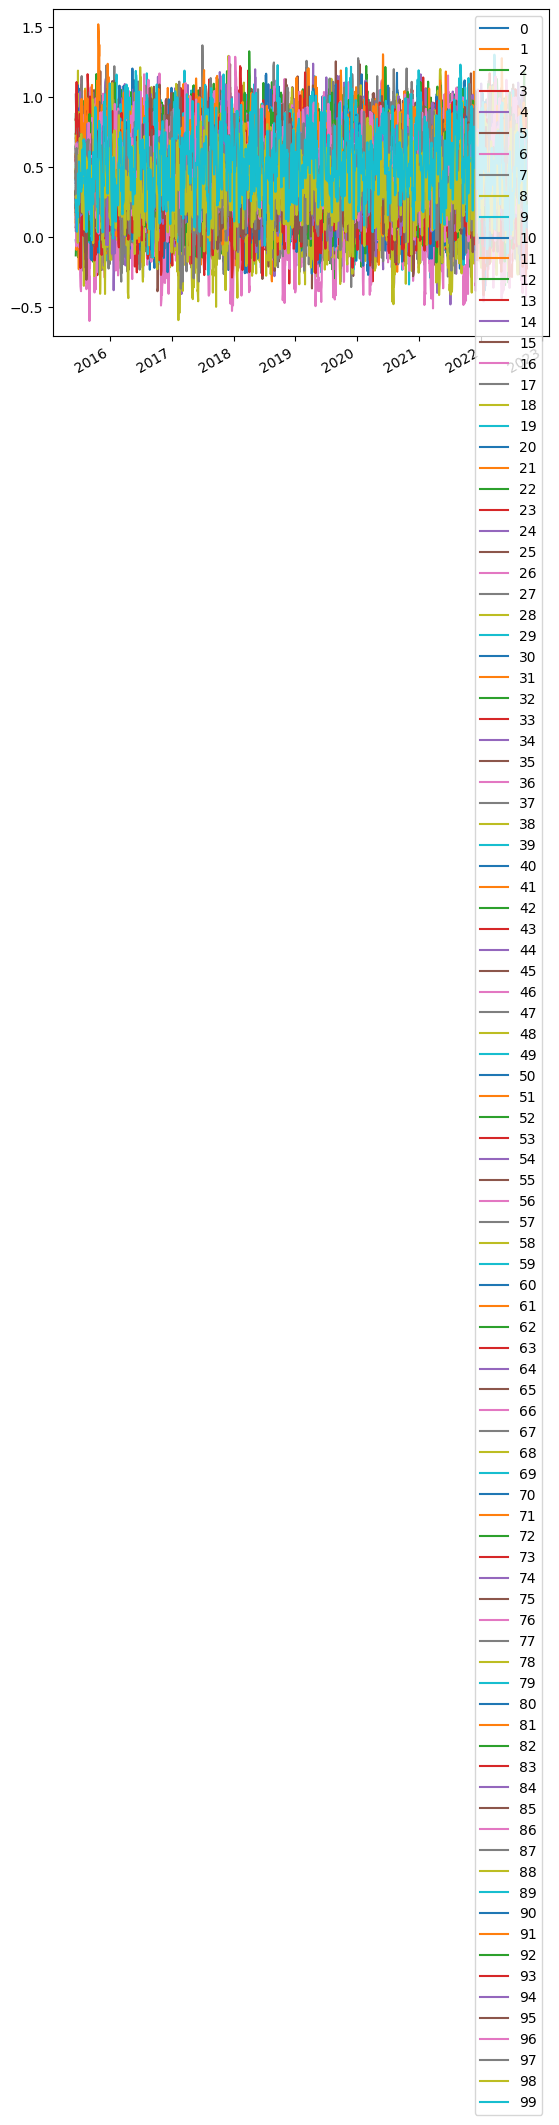

In [44]:
test_repr_il.plot()

In [42]:
# data_dict[file[:-4]]['X_DATA_DICT']  
#  

results = {}

mean = 0

for TEST_ASSET in  list( data_dict.keys() )[:]:
    print("\n", TEST_ASSET)
    results[TEST_ASSET] = {}
    
    num_test_intances = int(pct_train*len(data_dict[TEST_ASSET]['Y_DATA']))
    x_data_index = pd.DatetimeIndex( data_dict[TEST_ASSET]['X_DATA_DICT'].keys() )
    data_dict[TEST_ASSET]['Y_DATA'].index  = pd.to_datetime( data_dict[TEST_ASSET]['Y_DATA'].index )

    idx = data_dict[TEST_ASSET]['Y_DATA'].dropna().index.intersection(x_data_index)
    test_y = data_dict[TEST_ASSET]['Y_DATA'][:].loc[idx].iloc[:] #.dropna()

    test_x = { pd.to_datetime( idx ): val for idx, val in data_dict[TEST_ASSET]['X_DATA_DICT'].items() }

    # print( len(test_x) )
    # print( len(test_y) )

    encoding_window_method = ['full_series', 'net_compression']
    test_name = 'one_day_price_pred'
    for encoding_window in encoding_window_method:
        print(encoding_window)
        arrar_for_df = [ model.encode(test_x[idx][np.newaxis, ...], encoding_window=encoding_window).reshape(-1) for idx in test_y.index ]

        test_repr_il = pd.DataFrame(arrar_for_df, index = test_y.index)

        X_train, X_test, y_train, y_test = train_test_split(test_repr_il, test_y, test_size=0.33, random_state=42)
        # reg = linear_model.LinearRegression()
        reg = RidgeClassifier()
        # reg = linear_model.Lasso(alpha=0.1)

        clf = ExtraTreesClassifier(n_estimators=50)
        clf = clf.fit(X_train, np.sign( y_train[test_name] ))
        feat_selec_model = SelectFromModel(clf, prefit=True)
        X_train = feat_selec_model.transform(X_train)
        X_test = feat_selec_model.transform(X_test)

        reg.fit( X_train, np.sign( y_train[test_name] ) )

        results[TEST_ASSET][encoding_window] = reg.score(X_test,  np.sign( y_test[test_name] ) )
        
        print( reg.score(X_train, np.sign( y_train[test_name] ) ) )
        print(results[TEST_ASSET][encoding_window])
        # print( reg.score(X_test,  np.sign( y_test[test_name] ) ) )

    # print(results[TEST_ASSET]['full_series'], results[TEST_ASSET]['net_compression'] )
        
    mean += results[TEST_ASSET]['full_series'] < results[TEST_ASSET]['net_compression']

mean /= len(results.keys())


print( "\n net_compression acheives better results ", mean, "% of the times " )


 CSCO
full_series
0.573051948051948
0.5049342105263158
net_compression
0.5852272727272727
0.4621710526315789

 TROW
full_series
0.5811688311688312
0.5164473684210527
net_compression
0.5917207792207793
0.5263157894736842

 ISRG
full_series
0.6047077922077922
0.5016447368421053
net_compression


KeyboardInterrupt: 

In [ ]:
idx = np.sign( y_test['one_day_price_pred'] )[ np.sign( y_test['one_day_price_pred'] ) != 0].index
for i in range(100):
    acc = ( np.sign( X_test )[i].loc[idx] == np.sign( y_test['one_day_price_pred'].loc[idx] ) ).mean()
    if acc > .52:
        print(i, acc)

In [ ]:
test_repr_il[2].plot()

In [ ]:
results[TEST_ASSET][encoding_window]

# TODO: Result has same values for all keys
mean = 0
for key in results.keys():
    print(key, results[TEST_ASSET]['full_series'], results[TEST_ASSET]['net_compression'])
    mean += results[TEST_ASSET]['full_series'] < results[TEST_ASSET]['net_compression']

mean /= len(results.keys())
mean

In [ ]:
test_repr_il[0].plot()

In [ ]:
### TEST LOSS FUNCTIONS
BATCH_SIZE              = 100
rnn                     = nn.LSTM(5, 20, batch_first=True).float()
loss_test_values        = torch.from_numpy( train_data[:BATCH_SIZE] ).float()
output, (hn, cn)        = rnn(loss_test_values)
hn                      = hn.squeeze(0)
loss_test_exp_values    = torch.from_numpy( exp_train_data[:BATCH_SIZE]).float()

print( "quadratic_contrastive_loss: ", quadratic_contrastive_loss(hn, loss_test_exp_values, delta=1) )
print( "expclr_loss: ", expclr_loss(hn, loss_test_exp_values, delta=1) )

# max_diff = get_max_norm(batch_f)
# similarity_measure(batch_f[0], batch_f[1], max_diff)

In [ ]:
# out = model._eval_with_pooling(torch.from_numpy( test_data[:64] ).to(torch.float), None, encoding_window='')

In [ ]:


# # # Load the ECG200 dataset from UCR archive
# train_data, train_labels, test_data, test_labels = datautils.load_ECG()
# # # (Both train_data and test_data have a shape of n_instances x n_timestamps x n_features)

# exp_feat = pd.DataFrame(  train_data.reshape(100, -1)[:,40:] )
# exp_feat = pd.DataFrame(  exp_feat.mean(axis=1) ).values


# # Train a TS2Vec model
# model = TS2Vec(
#     input_dims=1,
#     device=0,
#     output_dims=320
# )
# loss_log = model.fit(
#     train_data,
#     expert_features=exp_feat, #train_data.reshape(100, -1)[:,40:],
#     verbose=True
# )

# # Compute timestamp-level representations for test set
# test_repr_tl = model.encode(test_data)  # n_instances x n_timestamps x output_dims

# # Compute instance-level representations for test set
# test_repr_il = model.encode(test_data, encoding_window='full_series')  # n_instances x output_dims

# # Sliding inference for test set
# test_repr_si = model.encode(
#     test_data,
#     casual=True,
#     sliding_length=1,
#     sliding_padding=50
# )  # n_instances x n_timestamps x output_dims
# # (The timestamp t's representation vector is computed using the observations located in [t-50, t])

In [ ]:
# data, train_slice, valid_slice, test_slice, scaler, pred_lens, n_covariate_cols = datautils.load_forecast_csv("ETTh2")
# train_data = data[:, train_slice]
        
# # Train a TS2Vec model
# model = TS2Vec(
#     input_dims=1,
#     device=0,
#     output_dims=320
# )
# loss_log = model.fit(
#     train_data,
#     verbose=True
# )

# # Compute timestamp-level representations for test set
# test_repr = model.encode(test_data)  # n_instances x n_timestamps x output_dims

# # Compute instance-level representations for test set
# test_repr = model.encode(test_data, encoding_window='full_series')  # n_instances x output_dims

# # Sliding inference for test set
# test_repr = model.encode(
#     test_data,
#     casual=True,
#     sliding_length=1,
#     sliding_padding=50
# )  # n_instances x n_timestamps x output_dims
# # (The timestamp t's representation vector is computed using the observations located in [t-50, t])